In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import wandb
# from wandb.fastai import WandbCallback
# wandb.init(project="poke-gan",name='512-self-perceptual-cont')

# from perceptual import FeatureLoss

# Data

In [3]:
# filt allows to filter out only the first-gen pokemon. 
# Useful for overfitting a subset of the train-set
PATH = Path('../../Data/PokeDataset/')
filt = pd.read_csv('Pokemons.csv',header=None).values        
data = (ImageList.from_folder(PATH)
        .filter_by_func(lambda x: '1_Danbooru2019_Pokemon' not in str(x) and '2_Fire_Old' not in str(x))
        # .filter_by_func(lambda x: any([f[0] in str(x) for f in filt]))
        .split_none()
        .label_from_folder()
        .transform(get_transforms(max_lighting=None),size=512)
        .databunch(bs=32)
        .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])]))
# data.train_dl = data.train_dl.new(shuffle=False)

# Models

In [4]:
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False,dilation=1):
    "Same as fastai's conv_layer function but with support for dilated convs"
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding,dilation=dilation), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

class ResnetClassifier(nn.Module):
    def __init__(self,nc):
        super().__init__()
        self.body = nn.Sequential(*children(models.resnet18(True))[:-2])
        self.classif_head = nn.Sequential(PoolFlatten(),
                                          nn.BatchNorm1d(512,affine=False,track_running_stats=False),
                                          nn.Linear(512,nc)
                                         )
    def forward(self,x):
        x = self.body(x)
        feature = self.classif_head[:2](x)
        return feature,self.classif_head[-1](feature)    

class M8_512(nn.Module):
    def __init__(self,msg=False):
        super().__init__()
        ''' 512 latent '''
        self.initial = nn.Sequential(
            conv_layer(128,256,ks=3,leaky=0.2,norm_type=NormType.Batch),
            conv_layer(256,512,ks=3,leaky=0.2,norm_type=NormType.Batch))
        self.first_block = nn.Sequential( #16x16
            conv_layer(512,256,ks=5,leaky=0.2,norm_type=NormType.Batch),
            conv_layer(256,128,ks=5,leaky=0.2,norm_type=NormType.Batch),
            conv_layer(128,64,ks=5,leaky=0.2,norm_type=NormType.Batch),)
        self.second_block = nn.Sequential( #128x128
            nn.Sequential(*conv_layer(64,32,ks=5,leaky=0.2,norm_type=NormType.Batch,dilation=2,padding=4),
                          *conv_layer(32,48,ks=5,leaky=0.2,norm_type=NormType.Batch)),
            nn.Sequential(*conv_layer(48,24,ks=5,leaky=0.2,norm_type=NormType.Batch,dilation=4,padding=8),
                          *conv_layer(24,32,ks=5,leaky=0.2,norm_type=NormType.Batch,dilation=2,padding=4)))
        self.final = conv_layer(32,3,ks=5,use_activ=False,norm_type=NormType.Batch)
        self.tanh = nn.Tanh()
        self.trgb = nn.Sequential(
            conv_layer(128,3,ks=1,use_activ=False,norm_type=None), #32
            conv_layer(48,3,ks=1,use_activ=False,norm_type=None), #128
            conv_layer(32,3,ks=1,use_activ=False,norm_type=None),) #256
        self.blur1,self.pad1 = nn.AvgPool2d(2,1),nn.ReplicationPad2d((0,1,0,1))
        self.blur2,self.pad2 = nn.AvgPool2d(4,1),nn.ReplicationPad2d((1,2,1,2))
        self.init_pad = nn.ReplicationPad2d((1,1,1,1))
        self.msg = msg
    def forward(self,x):
        x = self.init_pad(x.view(-1,128,2,2))
        trgb = []
        for l in self.initial:
            x = l(x)
            x = F.interpolate(x,scale_factor=2,mode='bilinear')
        for i,l in enumerate(self.first_block):
            x = l(x)
            if i==2: x = self.blur1(self.pad1(x)) #64,64
            # if self.training and i==1: # 32x32
            if self.msg and self.training and i==1: # 32x32
                trgb.append(self.tanh(self.trgb[0](x)))
            x = F.interpolate(x,scale_factor=2,mode='bilinear')                            
        for i,l in enumerate(self.second_block):
            x = l(x)
            if i==0: x = self.blur1(self.pad1(x))
            if i==1: x = self.blur2(self.pad2(x))
            # if self.training:
            if self.msg and self.training:
                trgb.append(self.tanh(self.trgb[i+1](x)))
            x = F.interpolate(x,scale_factor=2,mode='bilinear')
        x = self.final(x)
        # return trgb + [self.tanh(x)] if self.training else self.tanh(x)
        return trgb + [self.tanh(x)] if self.msg and self.training else self.tanh(x)
    
class CombinedModel(nn.Module):
    def __init__(self,cls,gen):
        super().__init__()
        self.cls = cls
        self.gen = gen
        
    def forward(self,x):
        op_feat,op_classif = self.cls(x)
#         op_gen = self.gen(op_feat.view(-1,100,1,1))
        op_gen = self.gen(op_feat.view(-1,512,1,1))
        return op_classif,op_gen

# First schedule: simultaneous training
Simultaneously train classifier and generator. No perceptual loss. 

Slower training with higher memory requirements. Not useful.

In [ ]:
%matplotlib inline
from tqdm.notebook import tqdm
model.cls.load_state_dict(d_sub)
model.cuda()
epochs = 100
opt = torch.optim.AdamW(model.parameters(),lr=5e-3)
ce = nn.CrossEntropyLoss()
l1 = nn.L1Loss()
for epoch in range(epochs):
    loop = tqdm(data.train_dl)
    for i,(xb,yb) in enumerate(loop):
#         xb,yb = xb.cpu(),yb.cpu()
        op_classif,op_gen = model(xb)
        loss1 = ce(op_classif,yb)
        loss2 = l1(op_gen,xb)
        loss = loss1 + loss2
        loss.backward()
        opt.step()
        opt.zero_grad()
        loop.set_description(f'Epoch {epoch+1}/{epochs}')
        loop.set_postfix(loss1=loss1.item(),loss2=loss2.item())
#         if i==50: break
    fig,ax = plt.subplots(1,4)
    fig.set_figwidth(32)
    fig.set_figheight(8)
    op_gen = (op_gen+1)/2
    for i in range(4):
        ax[i].imshow(op_gen[2*i].permute(1,2,0).detach().cpu().numpy())
    fig.tight_layout()
    wandb.log({'plots':fig,'epoch':epoch})
    plt.show()
    plt.close('all')
torch.save(model.state_dict(),'combined-pretrain.pkl')

# Second schedule: self-perceptual

In [ ]:
# Pre-train classifier
from tqdm.notebook import tqdm
classif = ResnetClassifier(data.c)
classif.cuda()
epochs = 5
opt = torch.optim.AdamW(classif.parameters(),lr=5e-3)
ce = nn.CrossEntropyLoss()
# model.load_state_dict(torch.load('classif-only-resnet.pkl'))
for epoch in range(epochs):
    loop = tqdm(data.train_dl)
    for i,(xb,yb) in enumerate(loop):
        op_feat,op_classif = classif(xb)
        loss = ce(op_classif,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loop.set_description(f'Epoch {epoch+1}/{epochs}')
        loop.set_postfix(loss=loss.item())
torch.save(classif.state_dict(),'512-latent/classif-only-resnet.pkl')

In [5]:
class SelfPerceptual(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
        model.cls.eval()
        requires_grad(model.cls,False)
        self.hooks = hook_outputs(model.cls.body[i] for i in [3,5,6,7])
        self.wgts = [15,5,3,2]
        self.base_loss = F.l1_loss
    
    def gram_matrix(self,x):
        n,c,h,w = x.size()
        x = x.view(n, c, -1)
        return (x @ x.transpose(1,2))/(c*h*w)
    
    def make_features(self,x,clone=False):
        op_feat,_ = self.model.cls(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored],op_feat
    
    def forward(self,x,feats=True,msg=False):
        if feats:    
            orig_feat,op_feat = self.make_features(x,clone=True)
            op_gen = self.model.gen(op_feat.view(-1,512,1,1))
            gen_feat,_ = self.make_features(op_gen[-1] if msg else op_gen)
            if msg:
                x = [F.interpolate(x,scale_factor=1/2**i) for i in [4,2,1,0]]
                self.loss = [sum([self.base_loss(x[i],op_gen[i]) for i in range(4)])/4]
            else:
                self.loss = [self.base_loss(x,op_gen)]
            self.loss += [self.base_loss(f_in, f_out)*w
                                 for f_in, f_out, w in zip(orig_feat, gen_feat, self.wgts)]
            self.loss += [self.base_loss(self.gram_matrix(f_in), self.gram_matrix(f_out))*w**2 * 2e3
                             for f_in, f_out, w in zip(orig_feat, gen_feat, self.wgts)]
            return sum(self.loss),op_gen
        else:
            op_feat,_ = self.model.cls(x)
            op_gen = self.model.gen(op_feat.view(-1,512,1,1))
            if msg:
                x = [F.interpolate(x,scale_factor=1/2**i) for i in [4,2,1,0]]
                self.loss = sum([self.base_loss(x[i],op_gen[i]) for i in range(4)])/4
            else:
                self.loss = self.base_loss(x,op_gen)
            return self.loss,op_gen
    def __del__(self): self.hooks.remove()

In [18]:
MSG=True # A switch for multi-scale gradients
# data.c = 799
classif = ResnetClassifier(data.c)
gen = M8_512(MSG)
model = CombinedModel(classif,gen)
model.cls.load_state_dict(torch.load('512-latent/classif-only-resnet.pkl'))
model.cuda()
pass

wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


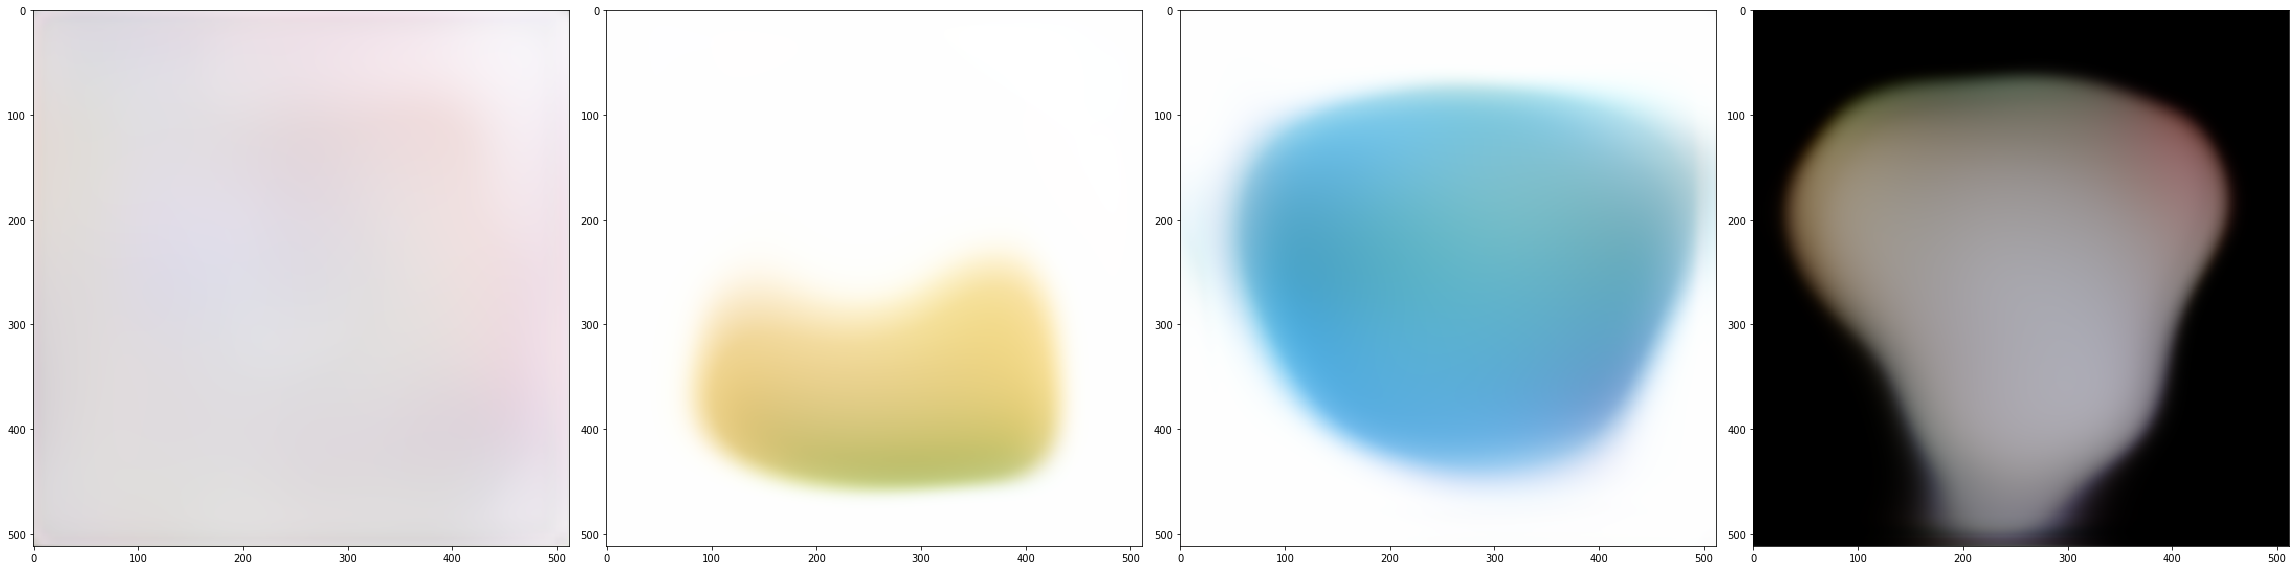

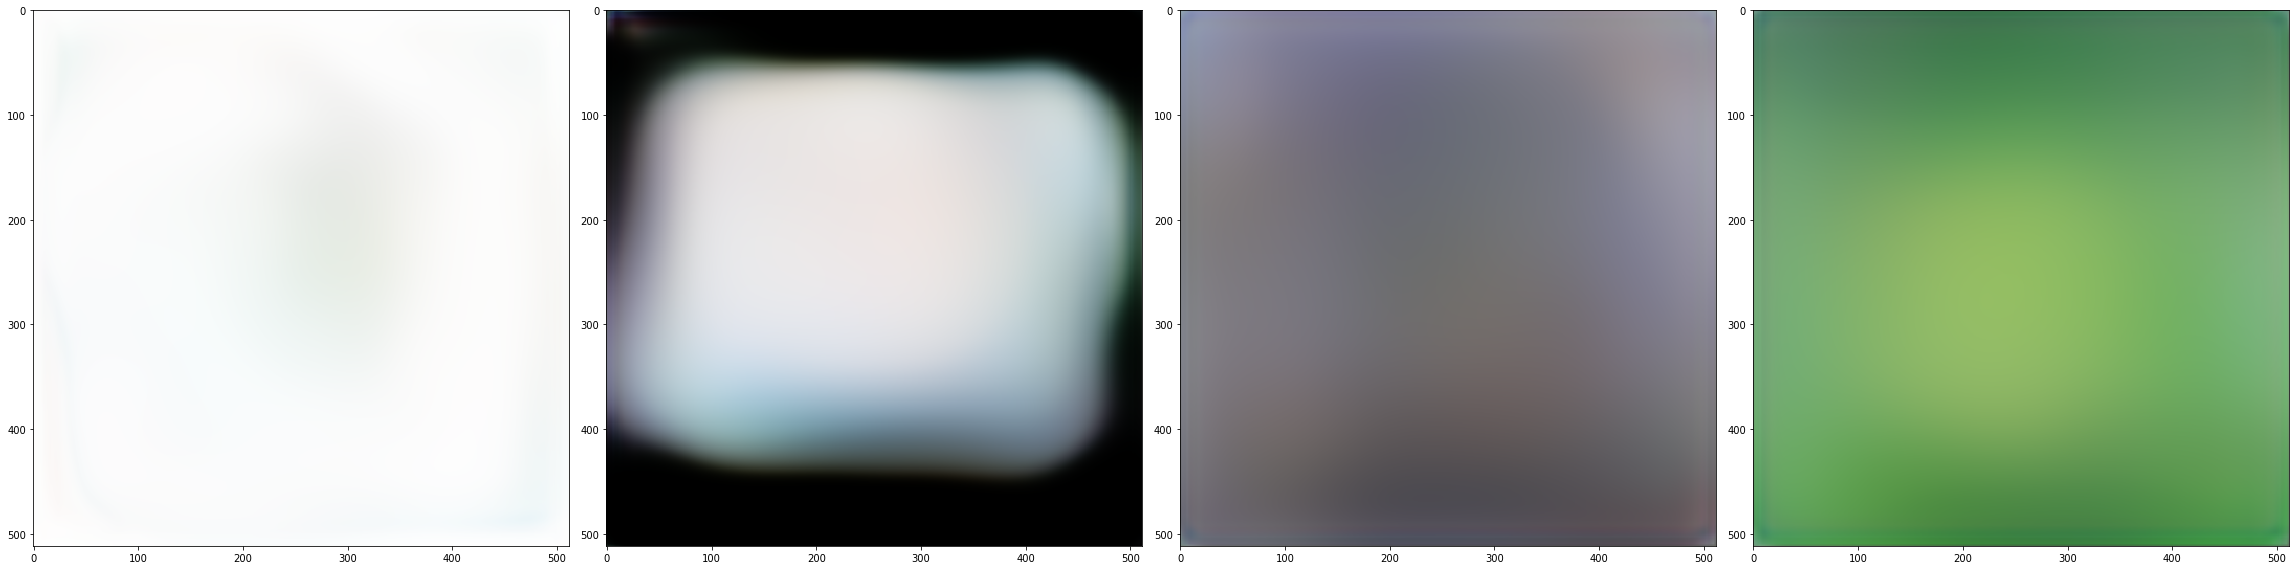

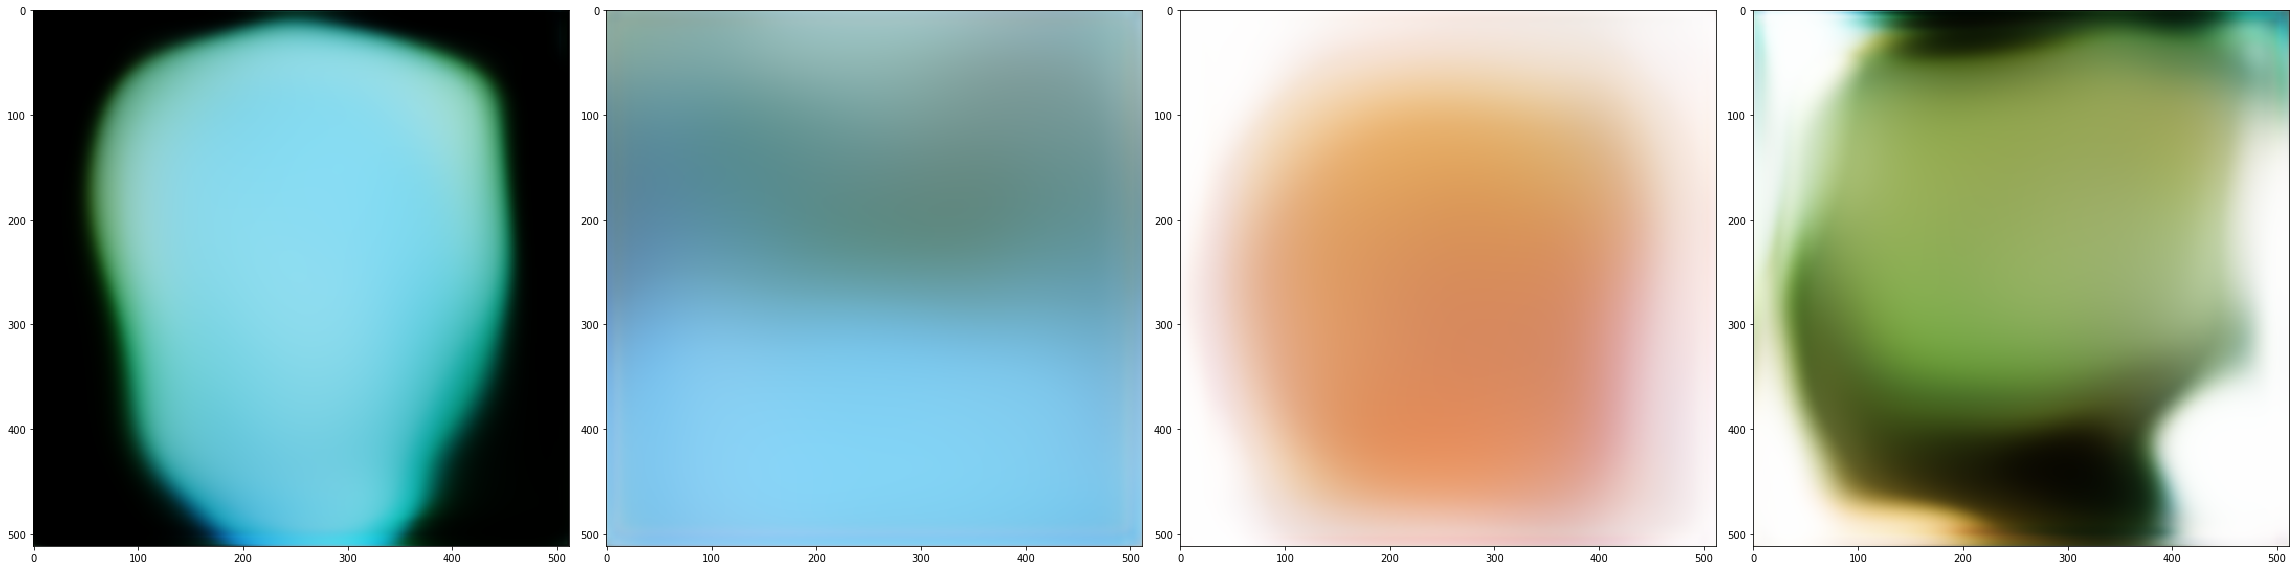

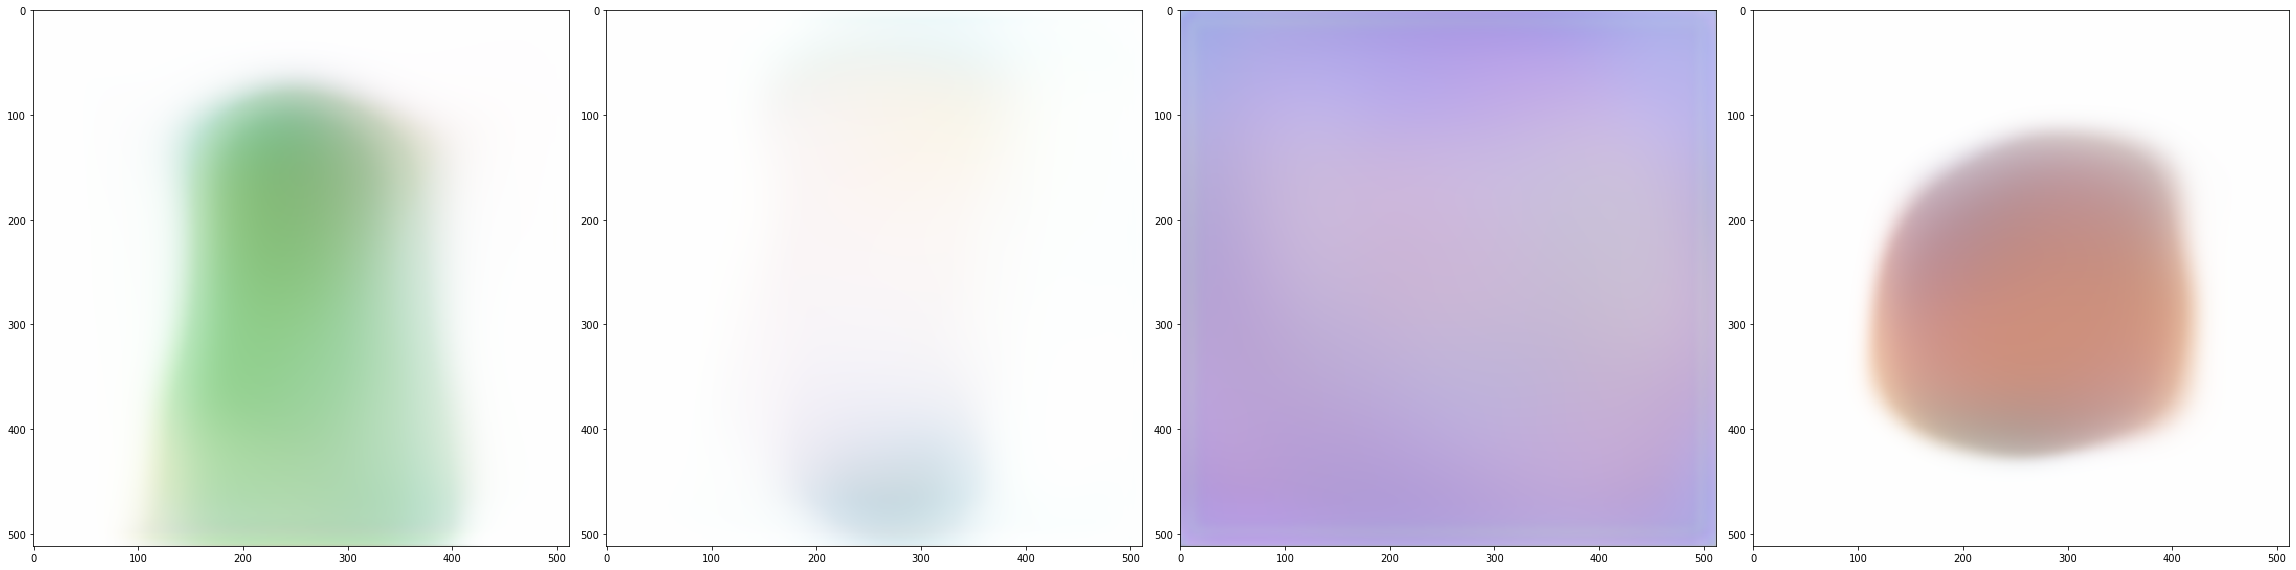

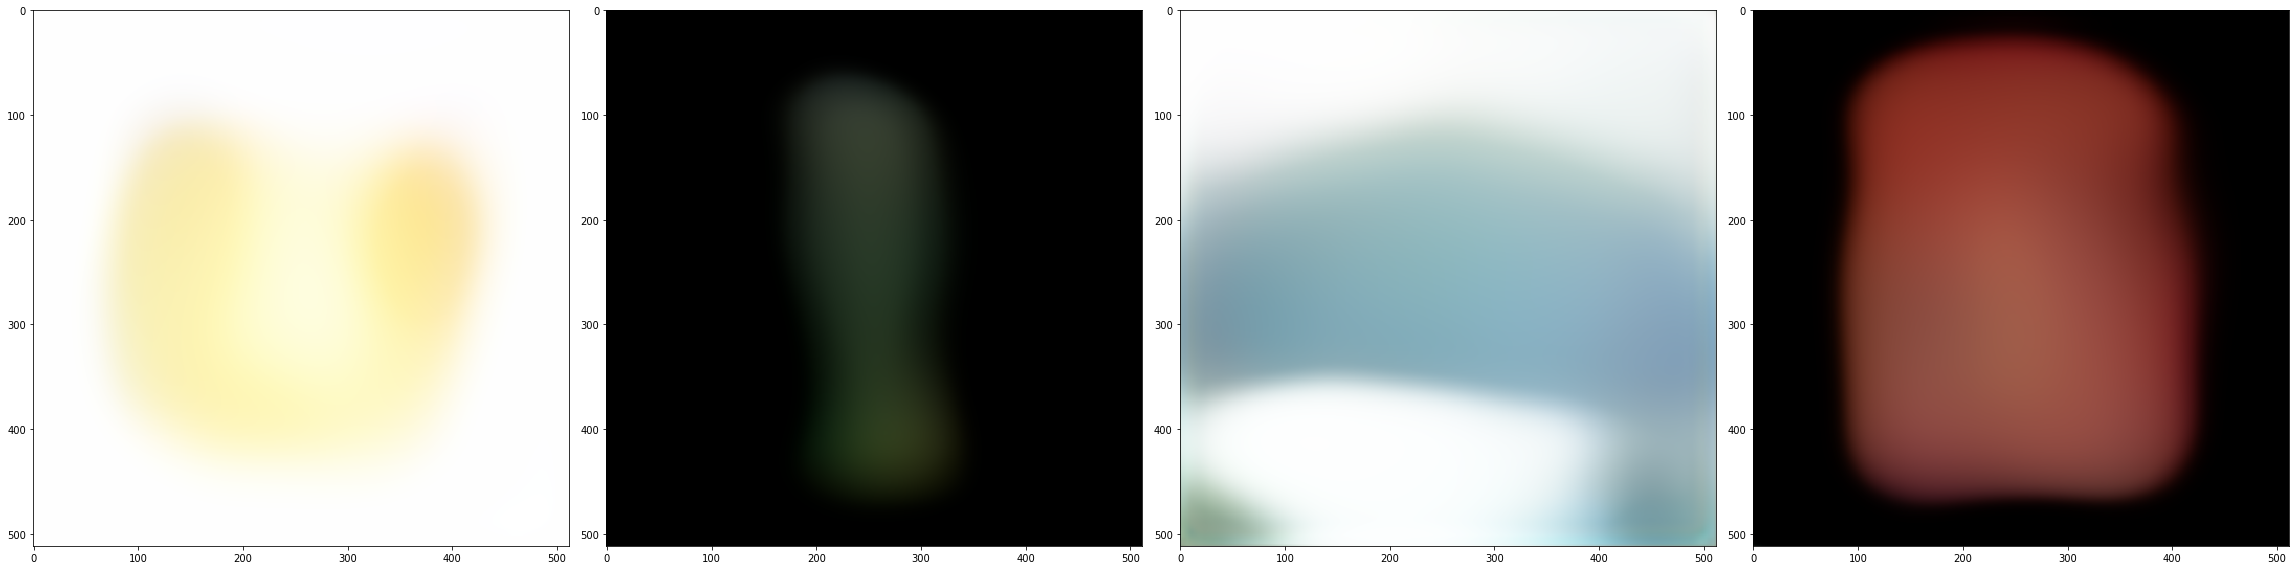

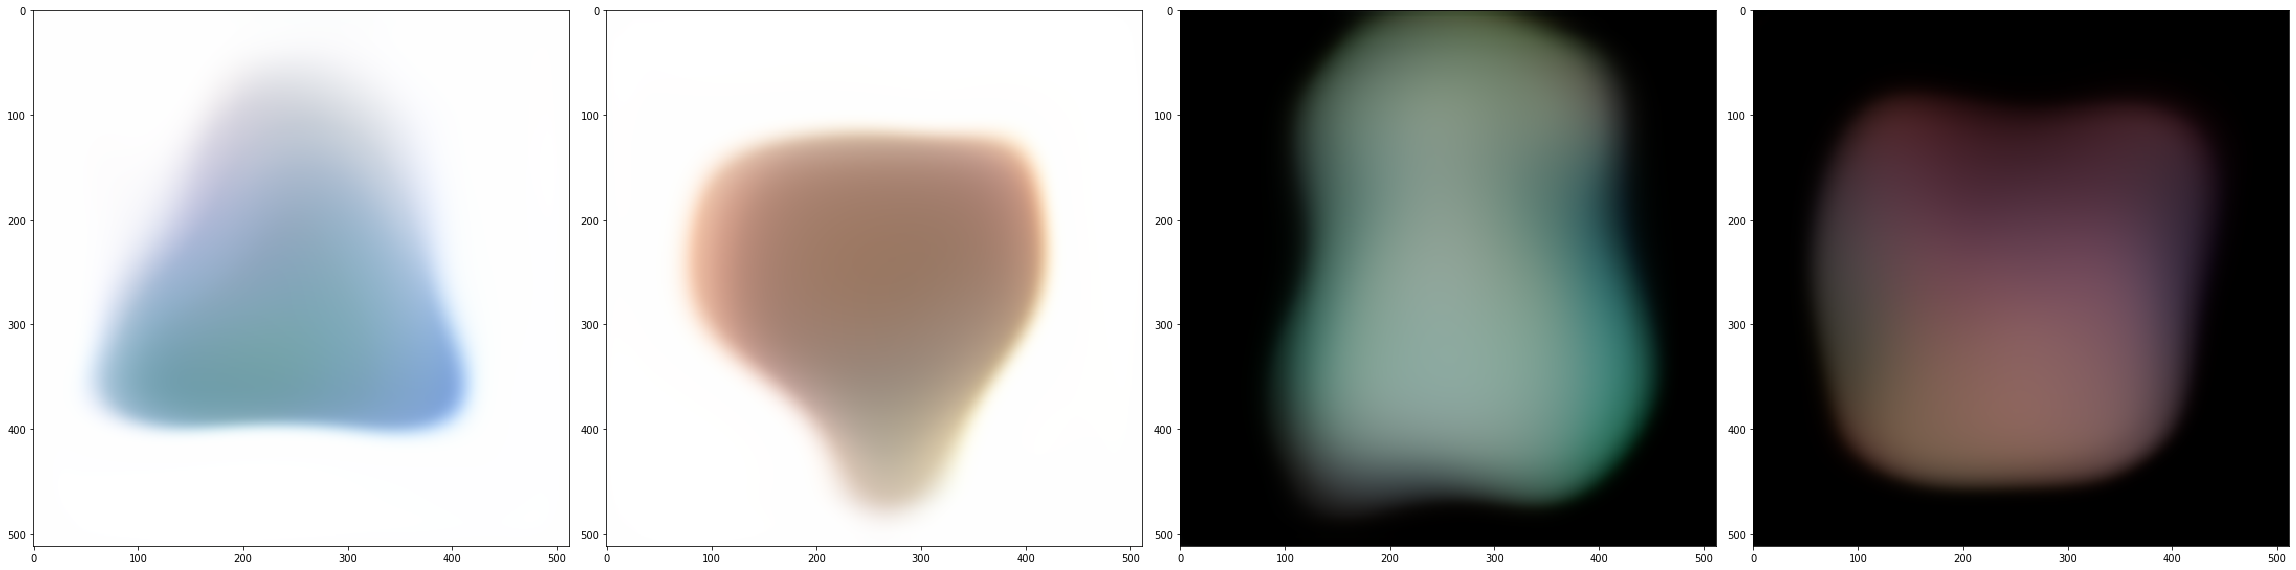

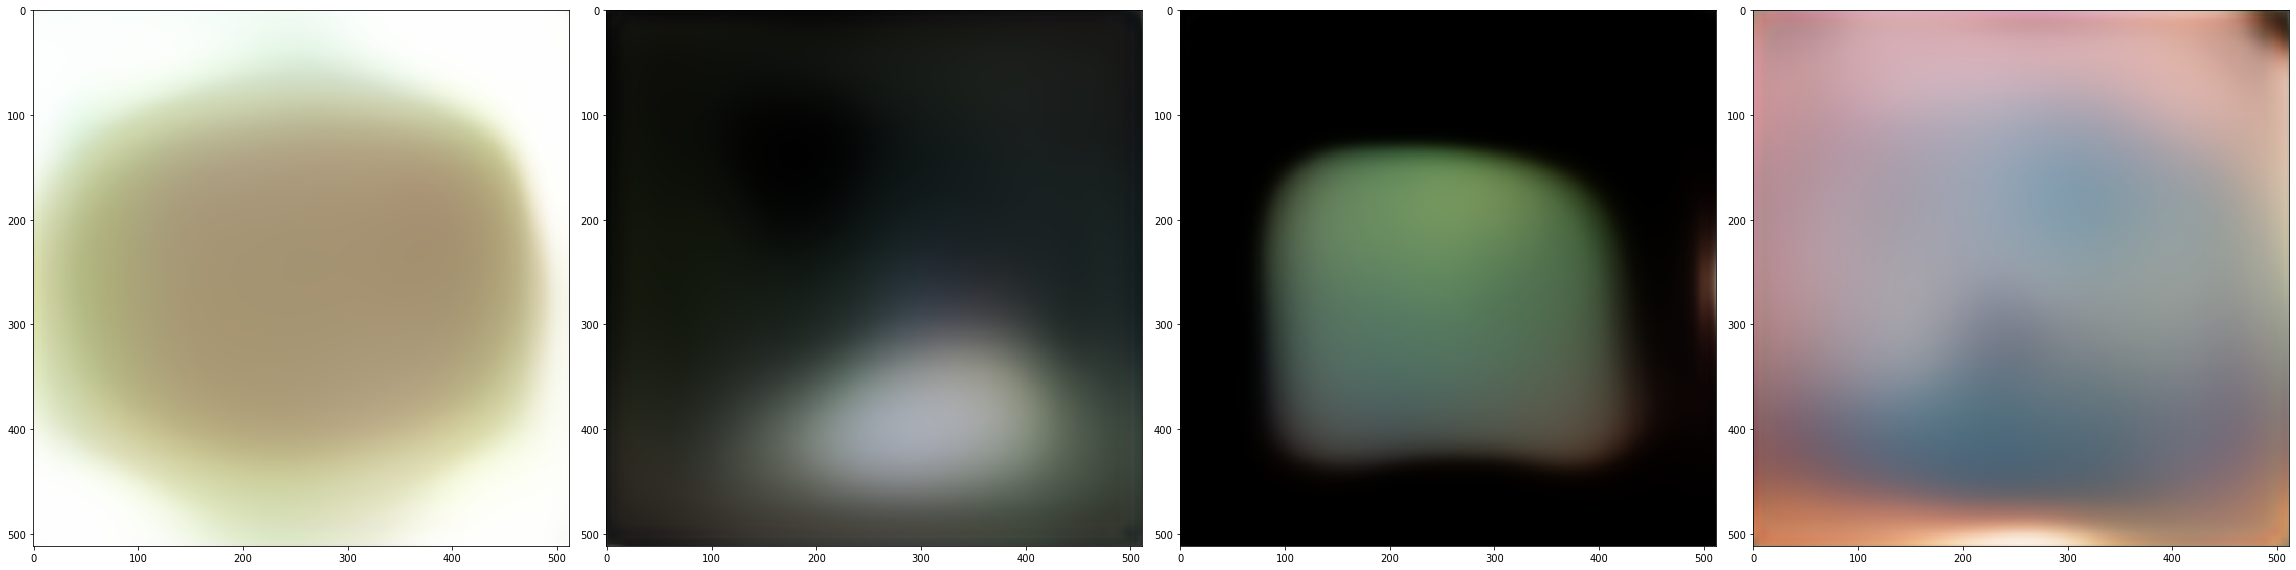

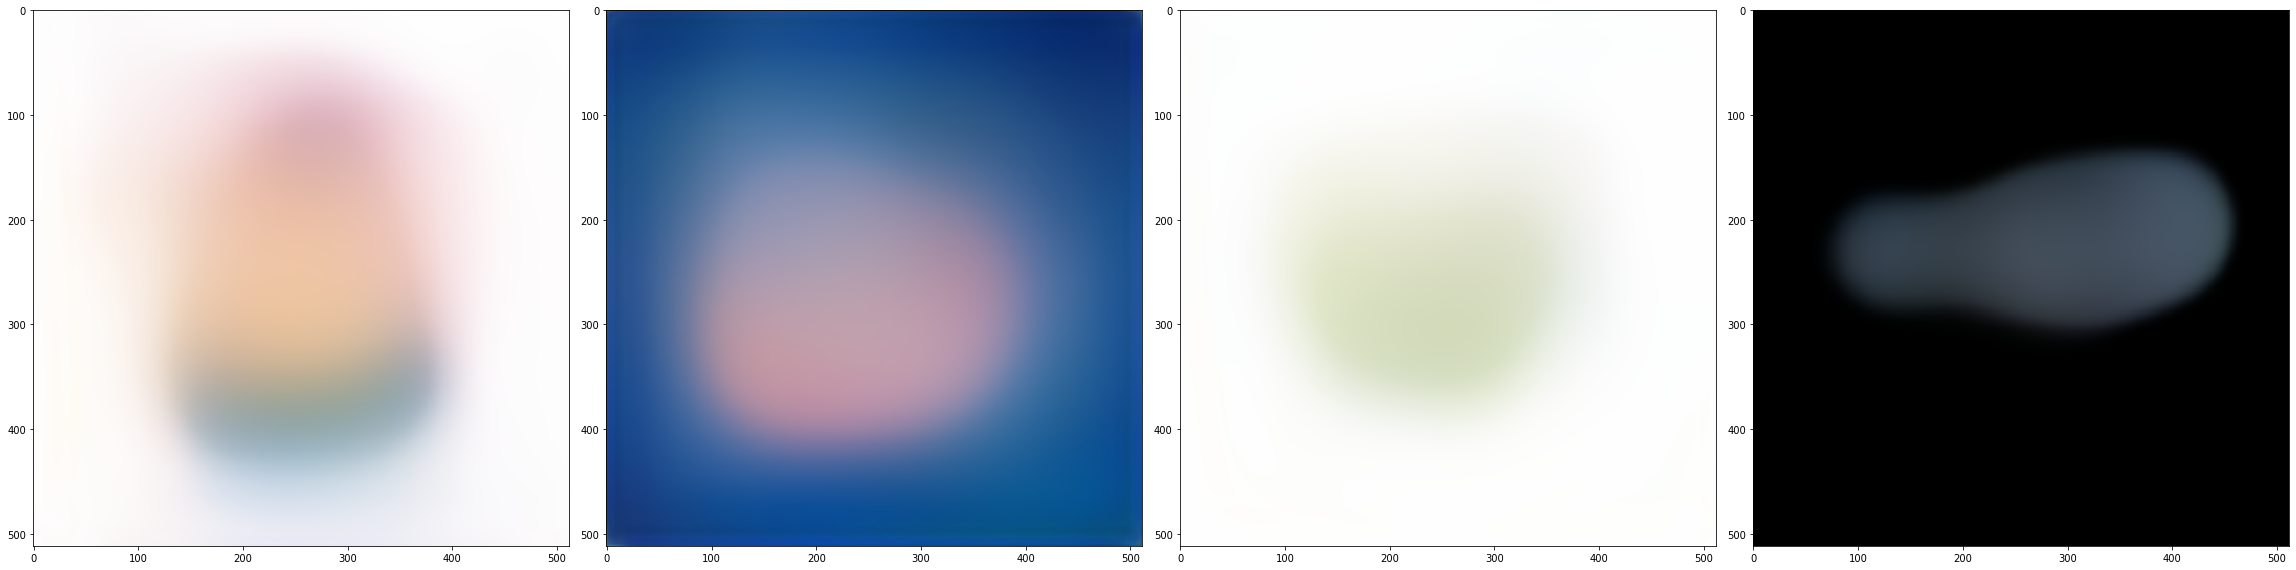

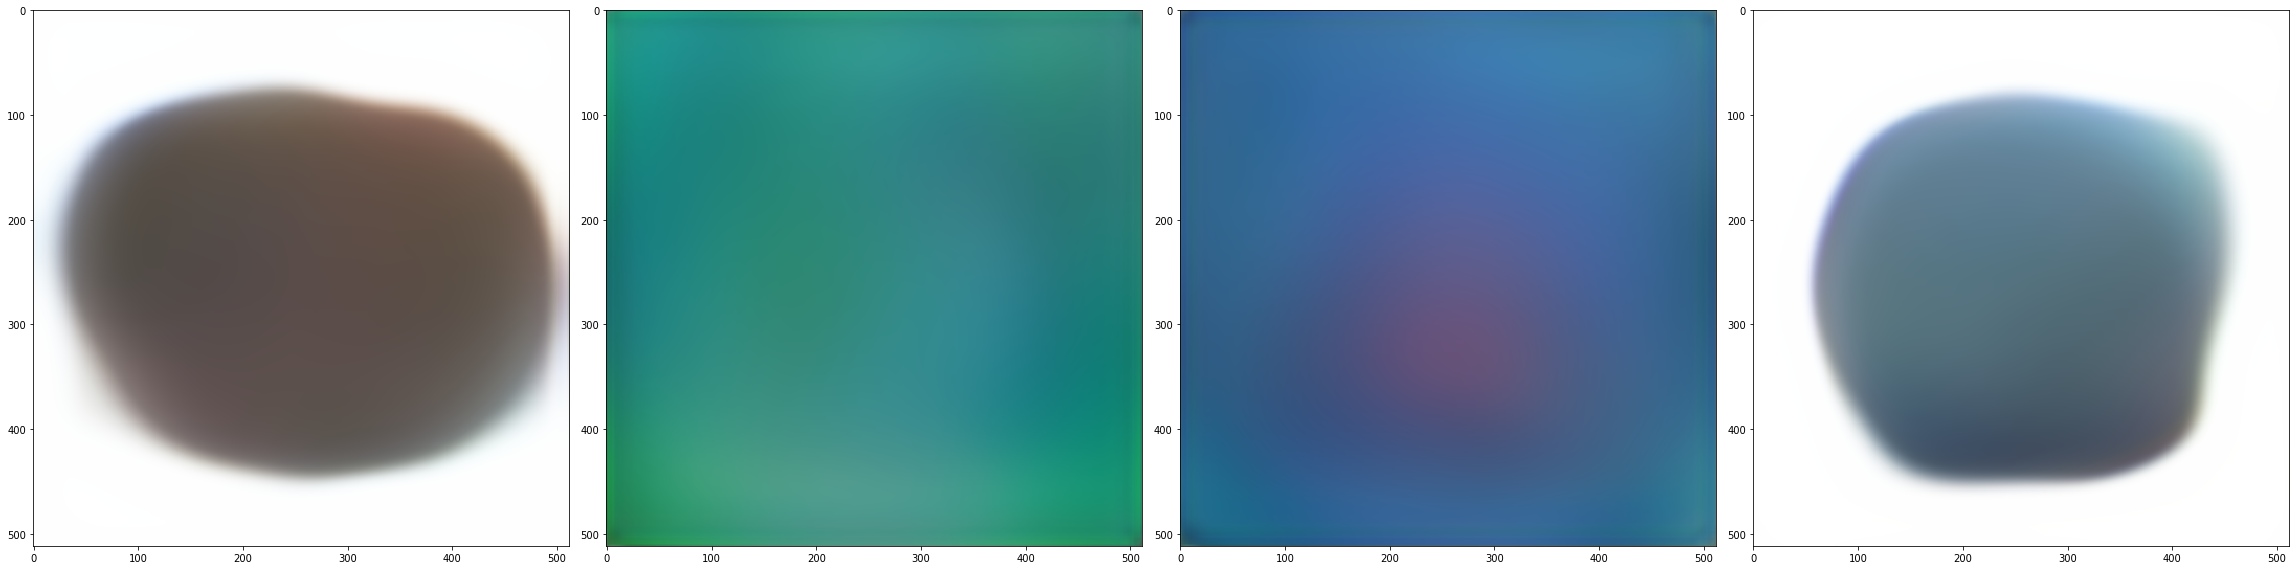

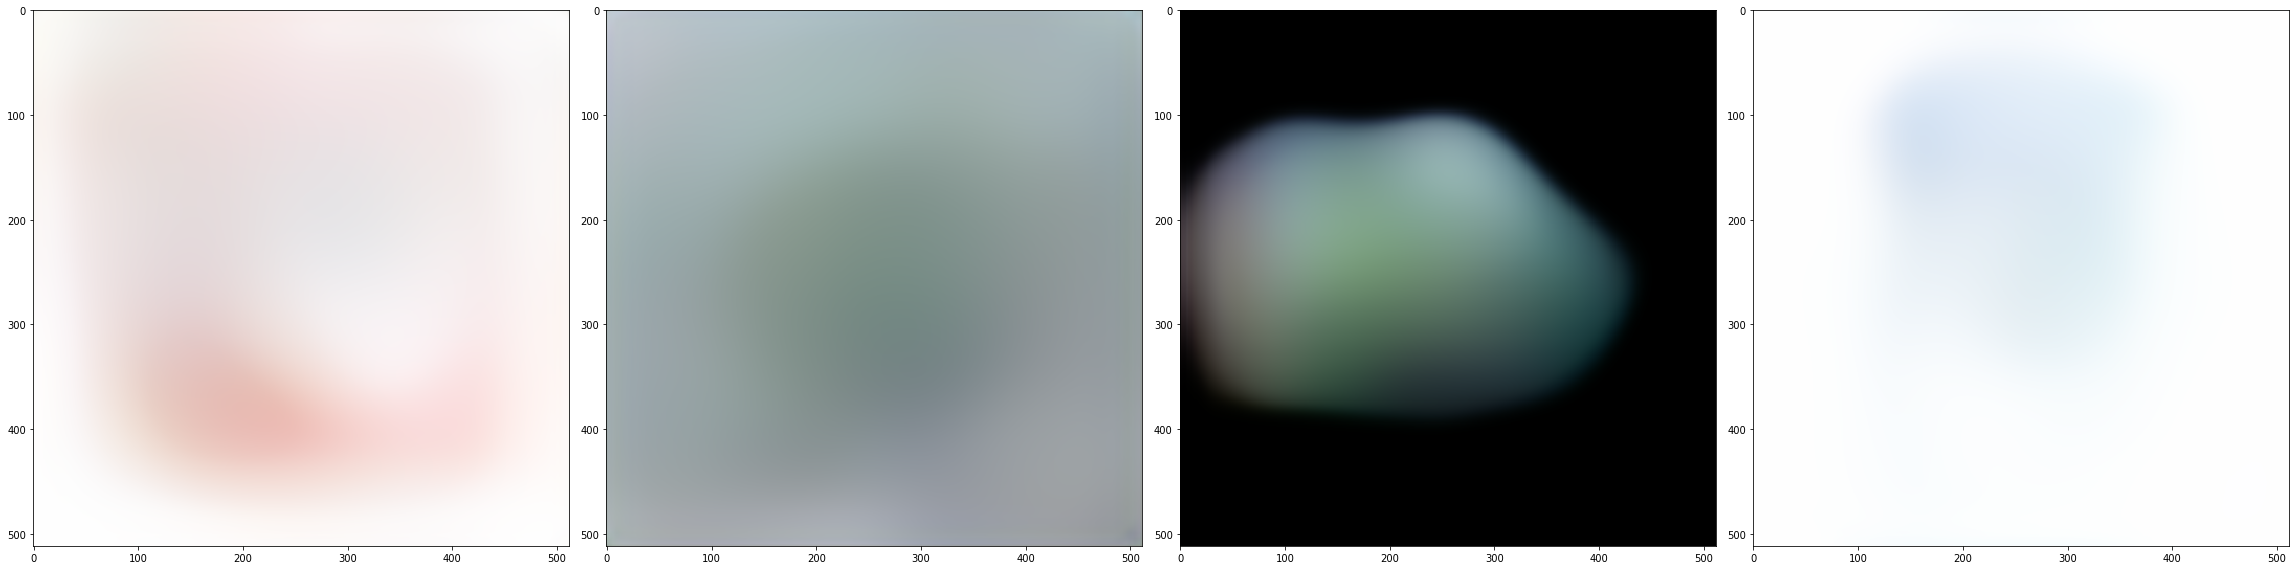

In [9]:
# Pre-train generator with multi-scale gradients
%matplotlib inline
from tqdm.notebook import tqdm
epochs = 20
loss_fn = SelfPerceptual(model)
opt = torch.optim.AdamW(model.parameters(),lr=5e-4)
for epoch in range(epochs):
    loop = tqdm(data.train_dl)
    for i,(xb,yb) in enumerate(loop):
        # loss,op_gen = loss_fn(xb,feats=False if epoch<1 else True,msg=MSG)
        loss,op_gen = loss_fn(xb,feats=True,msg=MSG)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loop.set_description(f'Epoch {epoch+1}/{epochs}')
        loop.set_postfix(loss=loss.item())
        # if i%10==9:break
    fig,ax = plt.subplots(1,4)
    fig.set_figwidth(32)
    fig.set_figheight(8)
    op_gen = (op_gen[-1]+1)/2 if MSG else (op_gen+1)/2
    for i in range(4):
        ax[i].imshow(op_gen[2*i].permute(1,2,0).detach().cpu().numpy())
    fig.tight_layout()
    if epoch%2==1: plt.show()
    wandb.log({'plots':fig,'epoch':epoch})
    if epoch%10==9: plt.show()
    plt.close('all')
torch.save(model.state_dict(),'512-latent/resnet-self-perceptual.pkl')

# Make GMM
Fit a Gaussian mixture model to the image embeddings. When training the GAN, instaed of sampling the noise from a standard normal distribution, sampling is done from this gmm.

In [9]:
# model.load_state_dict(torch.load('512-latemt/resnet-self-perceptual.pkl')).eval()
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=50,covariance_type='full')

In [10]:
model.cuda()
model.eval()
from tqdm.notebook import tqdm
feats = []
loop = tqdm(data.train_dl)
with torch.no_grad():
    for i,(xb,yb) in enumerate(loop):
        op_feat,_ = model.cls(xb)
        op_feat = op_feat.squeeze().detach().cpu().numpy()
        feats.append(op_feat)

In [11]:
feats_stack = np.concatenate(feats)

In [14]:
gmm.fit(feats_stack)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=50, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [15]:
import pickle 
with open('512-latent/GMM.pkl','wb') as f:
    pickle.dump(gmm,f)

In [ ]:
gmm.sample(32)[0].shape

# Inference

In [5]:
MSG=True
# data.c = 192
classif = ResnetClassifier(data.c)
gen = M8_512(MSG)
model = CombinedModel(classif,gen)
model.load_state_dict(torch.load('512-latent/resnet-self-perceptual-cont.pkl'))
# model.load_state_dict(torch.load('cg-resnet-preceptual.pkl'))
model.cuda()
pass

In [6]:
for x,_ in data.train_dl:
    break

In [7]:
x.shape

torch.Size([32, 3, 512, 512])

In [8]:
model.eval()
with torch.no_grad():
    _,y = model(x)

In [9]:
y.shape

torch.Size([32, 3, 512, 512])

In [10]:
from torchvision.utils import make_grid

In [18]:
ip = make_grid(x[[*list(range(6)),9,10,11]],nrow=3,range=(-1,1),normalize=True)

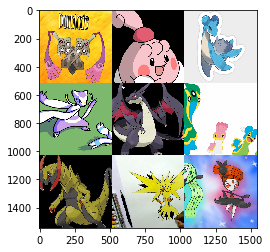

In [19]:
plt.imshow(ip.cpu().permute(1,2,0))

In [21]:
op = make_grid(y[[*list(range(6)),9,10,11]],nrow=3,range=(-1,1),normalize=True)

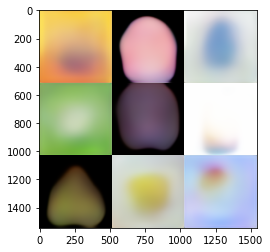

In [22]:
plt.imshow(op.cpu().permute(1,2,0).detach())

In [31]:
yr = model.gen(torch.randn(16,512,1,1).cuda())
opr = make_grid(yr[:9],nrow=3,range=(-1,1),normalize=True)

In [32]:
torchvision.utils.save_image(opr,fp='generate.png')

In [25]:
import torchvision.utils
torchvision.utils.save_image(op,fp='reconstruct.png')

In [27]:
torchvision.utils.save_image(ip,fp='input.png')